# ニューラルネットワーク

In [71]:
from chainer import cuda

In [30]:
chainer.__version__

'1.18.0'

In [31]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

### ステップ関数の実装

In [32]:
def step_function(x):
    if x > 0:
        return 1
    else:
        return 0

CuPyで再実装。

In [72]:
def step_function(x):
    xp = cuda.get_array_module(x)
    return xp.array(x > 0, dtype=cp.int8)

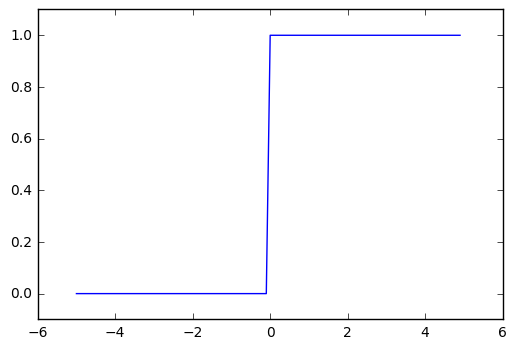

In [34]:
cp_x = cp.arange(-5.0, 5.0, 0.1)
cp_y = step_function(cp_x)

# CuPyのndarrayからNumPyのndarrayに変換
np_x = chainer.cuda.to_cpu(cp_x) 
np_y = chainer.cuda.to_cpu(cp_y)
plt.plot(np_x, np_y)  # グラフをプロット
plt.ylim(-0.1, 1.1)   # y軸の範囲を指定
plt.show()

### シグモイド関数の実装

In [73]:
def sigmoid(x):
    xp = cuda.get_array_module(x)
    return 1 / (1 + xp.exp(-x))

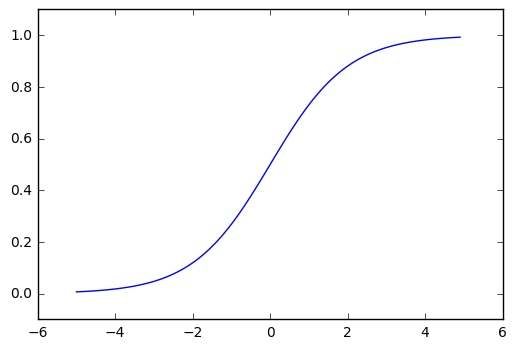

In [36]:
cp_x = cp.arange(-5.0, 5.0, 0.1)
cp_y = sigmoid(cp_x)

# CuPyのndarrayからNumPyのndarrayに変換
np_x = chainer.cuda.to_cpu(cp_x) 
np_y = chainer.cuda.to_cpu(cp_y)
plt.plot(np_x, np_y)  # グラフをプロット
plt.ylim(-0.1, 1.1)   # y軸の範囲を指定
plt.show()

### ReLu関数の実装

In [74]:
def relu(x):
    xp = cuda.get_array_module(x)
    return xp.maximum(0, x)

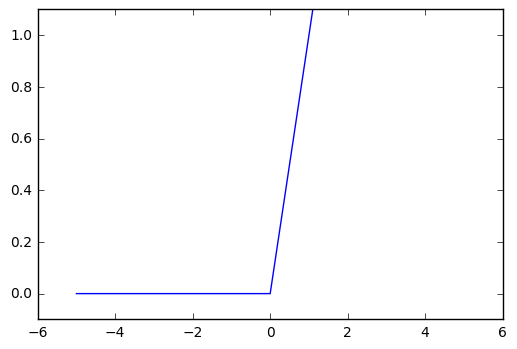

In [38]:
cp_x = cp.arange(-5.0, 5.0, 0.1)
cp_y = relu(cp_x)

# CuPyのndarrayからNumPyのndarrayに変換
np_x = chainer.cuda.to_cpu(cp_x) 
np_y = chainer.cuda.to_cpu(cp_y)
plt.plot(np_x, np_y)  # グラフをプロット
plt.ylim(-0.1, 1.1)   # y軸の範囲を指定
plt.show()

## 3層ニューラルネットワークの実装

In [75]:
def identity_function(x):
    return x

def init_network():
    network = {}
    network['W1'] = cp.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network['b1'] = cp.array([0.1, 0.2, 0.3])
    network['W2'] = cp.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network['b2'] = cp.array([0.1, 0.2])
    network['W3'] = cp.array([[0.1, 0.3], [0.2, 0.4]])
    network['b3'] = cp.array([0.1, 0.2])
    return network

def forword(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = cp.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = cp.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = cp.dot(z2, W3) + b3
    y = identity_function(a3)
    
    return y

In [76]:
network = init_network()
x = cp.array([1.0, 0.5])
y = forword(network, x)
print(y)

[ 0.31682708  0.69627909]


## 出力層の設計

### 恒等関数とソフトマックス関数

In [77]:
def softmax(a):
    xp = cuda.get_array_module(a)
    exp_a = xp.exp(a)
    sum_exp_a = xp.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

### ソフトマックス関数の実装上の注意点

ソフトマックス関数は内部で指数関数$e^x$を利用している。$x$が大きい値の場合、オーバーフローしてしまう恐れがある。これは入力信号の最大値を入力信号から引くことで改善することができる。

$$
    \begin{eqnarray}
    y_k = \frac{exp(a_k)}{\sum_{i=1}^{n} exp(a_i)} &=& \frac{C exp(a_k)}{C \sum_{i=1}^{n} exp(a_i)} \\
                                                   &=& \frac{exp(a_k + \log C)}{\sum_{i=1}^{n} exp(a_k + \log C)} \\
                                                   &=& \frac{exp(a_k + C')}{\sum_{i=1}^{n} exp(a_k + C')}
    \end{eqnarray}
$$

In [78]:
def softmax(a):
    xp = cuda.get_array_module(a)
    c = xp.max(a)
    exp_a = xp.exp(a - c) # オーバーフロー対策
    sum_exp_a = xp.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

## 手書き数字認識

In [43]:
import sys
import os

In [44]:
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートする

In [45]:
from dataset.mnist import load_mnist

「(訓練画像、訓練ラベル)、(テスト画像、テストラベル)」の形式でMNISTデータセットを取得。

In [46]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

In [47]:
print(x_train.shape)

(60000, 784)


In [48]:
print("x_train: {}\nt_train: {}\nx_test : {}\nt_test : {}\n".format(x_train.shape, t_train.shape, x_test.shape, t_test.shape))

x_train: (60000, 784)
t_train: (60000,)
x_test : (10000, 784)
t_test : (10000,)



MNIST画像を表示してみる。

In [49]:
from PIL import Image

In [50]:
img = x_train[0]
label = t_train[0]
print(label)

5


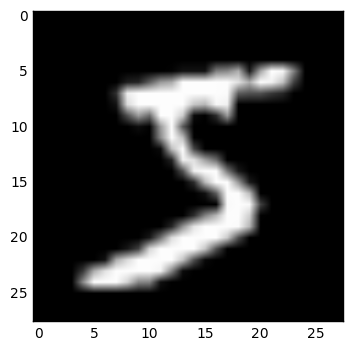

In [51]:
plt.imshow(img.reshape(28, 28), cmap='gray')

In [68]:
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open('sample_weight.pkl', 'rb') as rf:
        network = pickle.load(rf)
    return network

def predict(network, x):
    xp = chainer.cuda.get_array_module(network['W1'])
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    print('W1: {}'.format(type(W1)))
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    a1 = xp.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = xp.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = xp.dot(z2, W3) + b3
    y = softmax(a3)
    return y

### ニューラルネットワークの推論処理

numpyを用いて計算。

In [66]:
x, t = get_data()
network = init_network()

accuracy_count = 0
for i in range(len(x)):
    y = predict(network, x[i])
    xp = chainer.cuda.get_array_module(y)
    p = xp.argmax(y) # 最も確率の高い要素のインデックスを取得する
    if p == t[i]:
        accuracy_count += 1

print("Accuracy: {}".format(accuracy_count/len(x)))

Accuracy: 0.9352


cupyを用いて計算。

In [79]:
x, t = get_data()
network = init_network()
network['W1'] = cuda.to_gpu(network['W1'])
network['W2'] = cuda.to_gpu(network['W2'])
network['W3'] = cuda.to_gpu(network['W3'])
network['b1'] = cuda.to_gpu(network['b1'])
network['b2'] = cuda.to_gpu(network['b2'])
network['b3'] = cuda.to_gpu(network['b3'])

accuracy_count = 0
for i in range(len(cp_x)):
    y = predict(network, cp_x[i])
    p = cp.argmax(y) # 最も確率の高い要素のインデックスを取得する
    if p == cp_t[i]:
        accuracy_count += 1

print("Accuracy: {}".format(accuracy_count/len(x)))

W1: <class 'cupy.core.core.ndarray'>


ValueError: Axis dimension mismatch

### バッチ処理

In [32]:
x, t = get_data()
x, t = chainer.cuda.to_gpu(x), chainer.cuda.to_gpu(t)
network = init_network()

batch_size = 100
accuracy_count = 0
for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = cp.argmax(y_batch, axis=1)
    accuracy_count += cp.sum(p == t[i:i+batch_size])

print("Accuracy: {}".format(accuracy_count/len(x)))

Accuracy: 0.9352
